## 1) Import libraries

In [1]:
import sys
sys.path.append("./Tagging/lib/python3.6/site-packages")

import numpy as np
import pandas as pd

import re

import matplotlib.pyplot as plt

from functions import *

import pickle

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

from scipy import sparse

import math

In [2]:
def splitAtUpperCase(s):
    for i in range(len(s)-1)[::-1]:
        if s[i].isupper() and s[i+1].islower():
            s = s[:i]+' '+s[i:]
        if s[i].isupper() and s[i-1].islower():
            s = s[:i]+' '+s[i:]
        if s[i].isdigit() and s[i+1].isalpha():
            s = s[:i+1]+' '+s[i+1:]
        if s[i].isdigit() and s[i-1].isalpha():
            s = s[:i]+' '+s[i:]
        if s[i].isalpha() and s[i+1].isdigit():
            s = s[:i+1]+' '+s[i+1:]
        if s[i].isalpha() and s[i-1].isdigit():
            s = s[:i]+' '+s[i:]
    return s.split()

## 2) Import data

In [3]:
data = pd.read_csv("dataset_whole.csv", index_col = 0)

In [4]:
len(data["connRef"].unique())

37

In [5]:
data = pd.read_csv("dataset_whole.csv", index_col = 0)
data = data.drop(["inverted"],axis=1)
data_serviceType = pd.read_csv("dataset_whole_1.csv", index_col = 0)[["serviceType"]]

In [6]:
building_test = data["connRef"].unique()[0]

In [7]:
building_test

'LBG 50014000 Brindley Place'

In [8]:
test = data[data["connRef"]==building_test]
train = data[data["connRef"]!=building_test]

In [9]:
X_train = train[["navName", "connRef", "contractRef", "controllerReference", "pointReference","kind", "unit", "hisInterval", "hisSize"]]
X_test = test[["navName", "connRef", "contractRef", "controllerReference", "pointReference","kind", "unit", "hisInterval", "hisSize"]]

y_train = train.drop(["navName", "connRef", "contractRef", "controllerReference", "pointReference","kind", "unit", "hisInterval", "hisSize"], axis = 1)
y_test = test.drop(["navName", "connRef", "contractRef", "controllerReference", "pointReference","kind", "unit", "hisInterval", "hisSize"], axis = 1)

In [12]:
X_train.shape[0],X_test.shape[0]

(40472, 1820)

In [14]:
X_test.shape[0]/X_train.shape[0]*100

4.496936153389998

In [10]:
data.head()

navName                      connRef contractRef  \
0  5thFlr DX3 Cash Office Enable  LBG 50014000 Brindley Place         LBG   
1   DX Unit 3 5th Post Room Temp  LBG 50014000 Brindley Place         LBG   
2      6thFlr DX1 Kitchen Enable  LBG 50014000 Brindley Place         LBG   
3    DX Unit 1 Kitchen Room Temp  LBG 50014000 Brindley Place         LBG   
4      6thFlr DX2 Meeting Enable  LBG 50014000 Brindley Place         LBG   

  controllerReference pointReference    kind unit  hisInterval  hisSize  air  \
0               L1O11        D11(Sv)    Bool    0        300.0  58820.0    0   
1               L1O11         S10(V)  Number   °C        300.0  58822.0    1   
2               L1O11         D9(Sv)    Bool    0        300.0  58823.0    0   
3               L1O11          S8(V)  Number   °C        300.0  58816.0    1   
4               L1O11        D10(Sv)    Bool    0        300.0  58820.0    0   

   ...  recirc  return  run  sensor  sp  speed  temp  valve  water  zone  
0  ...       0       0    0       0   0      0     0      0      0     0  
1  ...       0       0    0       1   0      0     1      0      0     0  
2  ...       0       0    0       0   0      0     0      0      0     0  
3  ...       0       0    0       1   0      0     1      0      0     0  
4  ...       0       0    0       0   0      0     0      0      0     0  

[5 rows x 47 columns]

## 3) Parsing Data

### Uncomment when not selecting a specific building

In [11]:
#from sklearn.model_selection import train_test_split

In [12]:
#X = data[["navName", "connRef", "contractRef", "controllerReference", "pointReference","kind", "unit", "hisInterval", "hisSize"]]
#y = data.drop(["navName", "connRef", "contractRef", "controllerReference", "pointReference","kind", "unit", "hisInterval", "hisSize"], axis = 1)

In [13]:
#X_train, X_test, y_train, y_test, serviceType_train, serviceType_test = train_test_split(X.reset_index(drop=True), y.reset_index(drop=True), data_serviceType, test_size=0.1, random_state=42)

--------------------------------------------------------------------------------------------------

In [14]:
y_train_1 = y_train[["cmd", "sp", "sensor"]]
y_test_1 = y_test[["cmd", "sp", "sensor"]]

header = y_train.columns.tolist()
header.remove("cmd")
header.remove("sp")
header.remove("sensor")
y_train_2 = y_train[header]
y_test_2 = y_test[header]

### 3.1) Labels (navName)

In [15]:
labels_list_train = X_train[["navName"]].values.tolist()
labels_list_test = X_test[["navName"]].values.tolist()

In [16]:
# importing modules 
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
   
ps = PorterStemmer() 

In [17]:
dictionary = pd.read_csv("dict.csv",header=None).set_index(0).T.to_dict("list")

C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  """Entry point for launching an IPython kernel.


In [18]:
def labels_processing(labels_list, dictionary):
    labels = []
    for label in labels_list:
        
        #label = splitAtUpperCase(label[0])

        #label = label[0].lower()
        #print(label)
        #label = re.sub(r"[0-9]","",label)
        label = re.sub("[.]"," ",label[0])
        #label = label.lower().split()
        label = splitAtUpperCase(label)
        for i in range(0,len(label)):
            label[i] = label[i].lower()
            if label[i] in dictionary:
                label[i] = dictionary[label[i]][0]
        #label = " ".join(label)
        labels += [label] 
        
    return labels

In [19]:
labels_train = labels_processing(labels_list_train, dictionary)
labels_test = labels_processing(labels_list_test, dictionary)

In [20]:
labels = []
for w in labels_train:
    labels += [[ps.stem(word) for word in w]]
labels_train = labels
labels = []
for w in labels_test:
    labels += [[ps.stem(word) for word in w]]
labels_test = labels

In [21]:
labels_train = [" ".join(i) for i in labels_train]
labels_test = [" ".join(i) for i in labels_test]

In [22]:
from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
count_vect = CountVectorizer(ngram_range=(1,2))
count_vect.fit(labels_train)
count_vect.fit(labels_test)

CountVectorizer(ngram_range=(1, 2))

In [23]:
labels_sparse_train = count_vect.transform(labels_train)
labels_sparse_test = count_vect.transform(labels_test)

In [24]:
# Helper function
#def print_topics(model, count_vectorizer, n_top_words):
 #   words = count_vectorizer.get_feature_names()
  #  for topic_idx, topic in enumerate(model.components_):
   #     print("\nTopic #%d:" % topic_idx)
    #    print(" ".join([words[i]
     #                   for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [25]:
# Load the LDA model from sk-learn
#from sklearn.decomposition import LatentDirichletAllocation as LDA
# Tweak the two parameters below
#number_topics = 20
#number_words = 10
# Create and fit the LDA model
#lda = LDA(n_components=number_topics)
#lda.fit(labels_sparse_train)

In [26]:
#labels_sparse_train.shape

In [27]:
#lda_categories_train = lda.transform(labels_sparse_train)
#lda_categories_test = lda.transform(labels_sparse_test)

In [28]:
#print_topics(lda, count_vect, number_words)

In [29]:
#lda_sparse_train = sparse.csr_matrix(lda_categories_train)
#lda_sparse_test = sparse.csr_matrix(lda_categories_test)

### 3.2) Lan/outstation

In [30]:
lanOut = [re.sub("\D"," ",field[0]).split() for field in data[["controllerReference"]].values.tolist()]

lanOut_train = [re.sub("\D"," ",field[0]).split() for field in X_train[["controllerReference"]].values.tolist()]
lanOut_test = [re.sub("\D"," ",field[0]).split() for field in X_test[["controllerReference"]].values.tolist()]

In [31]:
#transform in "int" type the first vector member
for i in range(0, len(lanOut)):
    lanOut[i][0]=int(lanOut[i][0])
for i in range(0, len(lanOut_train)):
    lanOut_train[i][0]=int(lanOut_train[i][0])
for i in range(0, len(lanOut_test)):
    lanOut_test[i][0]=int(lanOut_test[i][0])

In [32]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
#X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc.fit(lanOut)

OneHotEncoder(handle_unknown='ignore')

In [33]:
lanOut_train = enc.transform(lanOut_train)
lanOut_test = enc.transform(lanOut_test)

In [34]:
lanOut_sparse_train = sparse.csr_matrix(lanOut_train)
lanOut_sparse_test = sparse.csr_matrix(lanOut_test)

In [35]:
lanOut_sparse_train.shape, lanOut_sparse_test.shape

((40472, 155), (1820, 155))

### 3.3) Controller Ref

In [36]:
controllerRef = data[["pointReference"]].values.tolist()

controllerRef_train = X_train[["pointReference"]].values.tolist()
controllerRef_test = X_test[["pointReference"]].values.tolist()

In [37]:
#Substitute parenthesis by blank space
conRef_process1 = [re.sub("[()]"," ",controllerRef[i][0]) for i in range(0,len(controllerRef))]

conRef_process1_train = [re.sub("[()]"," ",controllerRef_train[i][0]) for i in range(0,len(controllerRef_train))]
conRef_process1_test = [re.sub("[()]"," ",controllerRef_test[i][0]) for i in range(0,len(controllerRef_test))]

In [38]:
third_field = [conRef_process1[i].split()[1] for i in range(0,len(conRef_process1))]

third_field_train = [conRef_process1_train[i].split()[1] for i in range(0,len(conRef_process1_train))]
third_field_test = [conRef_process1_test[i].split()[1] for i in range(0,len(conRef_process1_test))]

In [39]:
first_field = [conRef_process1[i][0] for i in range(0,len(conRef_process1))]

first_field_train = [conRef_process1_train[i][0] for i in range(0,len(conRef_process1_train))]
first_field_test = [conRef_process1_test[i][0] for i in range(0,len(conRef_process1_test))]

In [40]:
second_field = [conRef_process1[i].split()[0][1:] for i in range(0,len(conRef_process1))]

second_field_train = [conRef_process1_train[i].split()[0][1:] for i in range(0,len(conRef_process1_train))]
second_field_test = [conRef_process1_test[i].split()[0][1:] for i in range(0,len(conRef_process1_test))]

In [41]:
conRef = [[first_field[i],second_field[i],third_field[i]] for i in range(0, len(first_field))]

conRef_train = [[first_field_train[i],second_field_train[i],third_field_train[i]] for i in range(0, len(first_field_train))]
conRef_test = [[first_field_test[i],second_field_test[i],third_field_test[i]] for i in range(0, len(first_field_test))]

In [42]:
enc_ref = OneHotEncoder(handle_unknown='ignore')
#X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc_ref.fit(conRef)

OneHotEncoder(handle_unknown='ignore')

In [43]:
conRef_train = enc_ref.transform(conRef_train)
conRef_test = enc_ref.transform(conRef_test)

In [44]:
conRef_sparse_train = sparse.csr_matrix(conRef_train)
conRef_sparse_test = sparse.csr_matrix(conRef_test)

In [45]:
conRef_sparse_train.shape, conRef_sparse_test.shape

((40472, 237), (1820, 237))

### 3.4) Kind

In [46]:
kind = data[["kind"]].values.tolist()

kind_train = X_train[["kind"]].values.tolist()
kind_test = X_test[["kind"]].values.tolist()

enc_kind = OneHotEncoder(handle_unknown='ignore')
#X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc_kind.fit(kind)

OneHotEncoder(handle_unknown='ignore')

In [47]:
kind_train = enc_kind.transform(kind_train)
kind_test = enc_kind.transform(kind_test)

In [48]:
kind_sparse_train = sparse.csr_matrix(kind_train)
kind_sparse_test = sparse.csr_matrix(kind_test)

### 3.5) Units

In [49]:
units = data[["unit"]].values.tolist()

units_train = X_train[["kind"]].values.tolist()
units_test = X_test[["kind"]].values.tolist()

enc_units = OneHotEncoder(handle_unknown='ignore')
#X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc_units.fit(units)

OneHotEncoder(handle_unknown='ignore')

In [50]:
units_train = enc_units.transform(units_train)
units_test = enc_units.transform(units_test)

In [51]:
units_sparse_train = sparse.csr_matrix(units_train)
units_sparse_test = sparse.csr_matrix(units_test)

## 4) Concatenate all

In [52]:
sX_train = sparse.hstack([labels_sparse_train,conRef_sparse_train,lanOut_sparse_train,kind_sparse_train,units_sparse_train])
sX_test = sparse.hstack([labels_sparse_test,conRef_sparse_test,lanOut_sparse_test,kind_sparse_test,units_sparse_test])

In [53]:
sX_train.shape, sX_test.shape

((40472, 1108), (1820, 1108))

In [54]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import MultinomialNB

In [55]:
y_train_1_shaped = np.argmax(y_train_1.values, axis=1)
y_test_1_shaped = np.argmax(y_test_1.values, axis=1)

## Logistic regression

In [60]:
%%time

# initialize label powerset multi-label classifier
classifier_1 = LogisticRegression()

# train
classifier_1.fit(sX_train,y_train_1_shaped)

# predict
predictions = classifier_1.predict(sX_test)
predictions_train = classifier_1.predict(sX_train)
#predictions_val = classifier.predict(data_val)

# accuracy
print("Test accuracy = ",accuracy_score(y_test_1_shaped, predictions))
print("Train accuracy = ",accuracy_score(y_train_1_shaped, predictions_train))
print("\n")

Test accuracy =  0.9967032967032967
Train accuracy =  0.9983198260525795


Wall time: 943 ms


C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Random Forests

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [62]:
%%time

# initialize label powerset multi-label classifier
classifier_1 = RandomForestClassifier(n_estimators=100)

# train
classifier_1.fit(sX_train,y_train_1)

# predict
predictions = classifier_1.predict(sX_test)
predictions_train = classifier_1.predict(sX_train)
#predictions_val = classifier.predict(data_val)

# accuracy
print("Test accuracy = ",accuracy_score(y_test_1, predictions))
print("Train accuracy = ",accuracy_score(y_train_1, predictions_train))
print("\n")

Test accuracy =  0.987912087912088
Train accuracy =  0.9999505831191935


Wall time: 9.37 s


## XGBoost

In [56]:
%%time

# initialize label powerset multi-label classifier
classifier_1 = XGBClassifier()

# train
classifier_1.fit(sX_train,y_train_1_shaped)

# predict
predictions = classifier_1.predict(sX_test)
predictions_train = classifier_1.predict(sX_train)
#predictions_val = classifier.predict(data_val)

# accuracy
print("Test accuracy = ",accuracy_score(y_test_1_shaped, predictions))
print("Train accuracy = ",accuracy_score(y_train_1_shaped, predictions_train))
print("\n")

Test accuracy =  0.9884615384615385
Train accuracy =  0.9996787902747578


Wall time: 2.71 s


## Multinomial Naive Bayes

In [64]:
%%time

# initialize label powerset multi-label classifier
classifier_1 = MultinomialNB(fit_prior = True, class_prior=None)

# train
classifier_1.fit(sX_train,y_train_1_shaped)

# predict
predictions = classifier_1.predict(sX_test)
predictions_train = classifier_1.predict(sX_train)
#predictions_val = classifier.predict(data_val)

# accuracy
print("Test accuracy = ",accuracy_score(y_test_1_shaped, predictions))
print("Train accuracy = ",accuracy_score(y_train_1_shaped, predictions_train))
print("\n")

Test accuracy =  0.8769230769230769
Train accuracy =  0.9874975291559597


Wall time: 22 ms


## Linear SVC

In [65]:
%%time

# initialize label powerset multi-label classifier
classifier_1 = LinearSVC()

# train
classifier_1.fit(sX_train,y_train_1_shaped)

# predict
predictions = classifier_1.predict(sX_test)
predictions_train = classifier_1.predict(sX_train)
#predictions_val = classifier.predict(data_val)

# accuracy
print("Test accuracy = ",accuracy_score(y_test_1_shaped, predictions))
print("Train accuracy = ",accuracy_score(y_train_1_shaped, predictions_train))
print("\n")

Test accuracy =  0.9950549450549451
Train accuracy =  0.9984927851354023


Wall time: 152 ms


In [58]:
predictions = np.reshape(predictions,(-1,1))

enc = OneHotEncoder(handle_unknown='ignore')
#X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc.fit(predictions)
spredictions = enc.transform(predictions)

In [59]:
#spredictions = sparse.csr_matrix(predictions) 

In [60]:
#Preparing new test data (test_1 + predictions)
#spredictions = sparse.csr_matrix(np.reshape(predictions, (-1,1)).shape) 
sX_test_2 = sparse.hstack([sX_test,spredictions])

#Preparing new training data (train_1 + y_train_1)
sX_train_2 = sparse.hstack([sX_train,y_train_1])

# Second stage

## Logistic Regression

In [69]:
results_2 = np.empty(sX_test_2.shape[0])
results_2 = np.reshape(results_2, (-1,1))

results_train_2 = np.empty(sX_train_2.shape[0])
results_train_2 = np.reshape(results_train_2, (-1,1))

probabilities_2 = np.empty(sX_test_2.shape[0])
probabilities_2 = np.reshape(probabilities_2, (-1,1))

for category in list(y_train_2):
    
    #print(y_train_2[[category]])
    
    classifier_2 = LogisticRegression()
    classifier_2.fit(sX_train_2, y_train_2[[category]].reset_index(drop=True))
    
    # predict
    predictions_2 = classifier_2.predict(sX_test_2)
    probs_2 = classifier_2.predict_proba(sX_test_2)
    
    predictions_train_2 = classifier_2.predict(sX_train_2)
    #predictions_val = classifier.predict(data_val)
    
    predictions_2 = np.reshape(predictions_2, (-1,1))
    results_2 = np.concatenate((results_2, predictions_2), axis=1)
    
    predictions_train_2 = np.reshape(predictions_train_2, (-1,1))
    results_train_2 = np.concatenate((results_train_2, predictions_train_2), axis=1)
    
    #probs_2 = np.reshape(probs_2, (-1,1))
    
    probs_2 = probs_2[:,[1]]
    print(probs_2.shape)
    
    probabilities_2 = np.concatenate((probabilities_2, probs_2), axis=1)
    
    # accuracy
    print(category)
    print(probabilities_2.shape)
    print("Training Accuracy = ",accuracy_score(y_train_2[[category]],predictions_train_2))
    print("Test Accuracy = ",accuracy_score(y_test_2[[category]],predictions_2))
    print("\n")

results_2 = np.delete(results_2, 0, 1)
results_train_2 = np.delete(results_train_2, 0, 1)
probabilities_2 = np.delete(probabilities_2, 0, 1)

y_test_2.shape, results_2.shape

y_train_2.shape, results_train_2.shape

print("\n")
print("TOTAL TRAINING AND TEST ACCURACY")
print("\n")
print("Training Accuracy = ",accuracy_score(y_train_2,results_train_2))
print("Test Accuracy = ",accuracy_score(y_test_2,results_2))

C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

(1820, 1)
air
(1820, 2)
Training Accuracy =  0.9595028661790868
Test Accuracy =  0.9868131868131869




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


(1820, 1)
alarm
(1820, 3)
Training Accuracy =  0.9765516900573236
Test Accuracy =  0.9901098901098901


(1820, 1)
chilled
(1820, 4)
Training Accuracy =  0.9968867365091916
Test Accuracy =  0.9989010989010989


(1820, 1)
co2
(1820, 5)
Training Accuracy =  0.9997529155959676
Test Accuracy =  0.9961538461538462




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


(1820, 1)
cool
(1820, 6)
Training Accuracy =  0.9977268234829018
Test Accuracy =  0.9989010989010989


(1820, 1)
damper
(1820, 7)
Training Accuracy =  0.9992340383474995
Test Accuracy =  0.9956043956043956




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

(1820, 1)
discharge
(1820, 8)
Training Accuracy =  0.9855455623641036
Test Accuracy =  0.9857142857142858


(1820, 1)
enable
(1820, 9)
Training Accuracy =  0.9995799565131449
Test Accuracy =  1.0


(1820, 1)
energy
(1820, 10)
Training Accuracy =  1.0
Test Accuracy =  1.0


(1820, 1)
entering
(1820, 11)
Training Accuracy =  0.9990363708242735
Test Accuracy =  0.9978021978021978




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


(1820, 1)
extract
(1820, 12)
Training Accuracy =  0.9971832377940304
Test Accuracy =  0.9972527472527473


(1820, 1)
fault
(1820, 13)
Training Accuracy =  0.9996540818343547
Test Accuracy =  1.0




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


(1820, 1)
flow
(1820, 14)
Training Accuracy =  0.9991352045858866
Test Accuracy =  0.9983516483516484


(1820, 1)


C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


frost
(1820, 15)
Training Accuracy =  0.9991104961454833
Test Accuracy =  1.0




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

(1820, 1)
heat
(1820, 16)
Training Accuracy =  0.9935510970547539
Test Accuracy =  0.9994505494505495


(1820, 1)
holdOff
(1820, 17)
Training Accuracy =  0.9987892864202411
Test Accuracy =  1.0


(1820, 1)
hot
(1820, 18)
Training Accuracy =  0.9961454832970943
Test Accuracy =  0.9994505494505495


(1820, 1)
humidity
(1820, 19)
Training Accuracy =  0.9981715754101601
Test Accuracy =  0.9994505494505495




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


(1820, 1)
humidifier
(1820, 20)
Training Accuracy =  0.9994317058707255
Test Accuracy =  1.0




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

(1820, 1)
leaving
(1820, 21)
Training Accuracy =  0.9956018976082229
Test Accuracy =  0.9978021978021978


(1820, 1)
maximum
(1820, 22)
Training Accuracy =  0.999382288989919
Test Accuracy =  1.0


(1820, 1)
minimum
(1820, 23)
Training Accuracy =  0.9986410357778217
Test Accuracy =  1.0


(1820, 1)
mixed
(1820, 24)
Training Accuracy =  0.9998023324767741
Test Accuracy =  0.9994505494505495


(1820, 1)


C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


occupied
(1820, 25)
Training Accuracy =  0.9999505831191935
Test Accuracy =  1.0




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


(1820, 1)
outside
(1820, 26)
Training Accuracy =  0.997133820913224
Test Accuracy =  1.0




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

(1820, 1)
override
(1820, 27)
Training Accuracy =  0.9889059102589445
Test Accuracy =  0.9994505494505495


(1820, 1)
pressure
(1820, 28)
Training Accuracy =  0.9961454832970943
Test Accuracy =  1.0


(1820, 1)
recirc
(1820, 29)
Training Accuracy =  0.9998023324767741
Test Accuracy =  1.0




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

(1820, 1)
return
(1820, 30)
Training Accuracy =  0.9841124728207156
Test Accuracy =  0.9873626373626374




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


(1820, 1)
run
(1820, 31)
Training Accuracy =  0.983544178691441
Test Accuracy =  0.9725274725274725


(1820, 1)
speed
(1820, 32)
Training Accuracy =  0.9981962838505634
Test Accuracy =  0.9972527472527473




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

(1820, 1)
temp
(1820, 33)
Training Accuracy =  0.9683484878434473
Test Accuracy =  0.9769230769230769


(1820, 1)
valve
(1820, 34)
Training Accuracy =  0.9961949001779008
Test Accuracy =  0.9983516483516484




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

(1820, 1)
water
(1820, 35)
Training Accuracy =  0.9914755880608817
Test Accuracy =  0.9961538461538462


(1820, 1)
zone
(1820, 36)
Training Accuracy =  0.9790719509784542
Test Accuracy =  0.9752747252747253




TOTAL TRAINING AND TEST ACCURACY


Training Accuracy =  0.8376655465507017
Test Accuracy =  0.8884615384615384


C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Random Forests

In [70]:
results_2 = np.empty(sX_test_2.shape[0])
results_2 = np.reshape(results_2, (-1,1))

results_train_2 = np.empty(sX_train_2.shape[0])
results_train_2 = np.reshape(results_train_2, (-1,1))

probabilities_2 = np.empty(sX_test_2.shape[0])
probabilities_2 = np.reshape(probabilities_2, (-1,1))

for category in list(y_train_2):
    
    #print(y_train_2[[category]])
    
    classifier_2 = RandomForestClassifier(n_estimators=100)
    classifier_2.fit(sX_train_2, y_train_2[[category]].reset_index(drop=True))
    
    # predict
    predictions_2 = classifier_2.predict(sX_test_2)
    probs_2 = classifier_2.predict_proba(sX_test_2)
    
    predictions_train_2 = classifier_2.predict(sX_train_2)
    #predictions_val = classifier.predict(data_val)
    
    predictions_2 = np.reshape(predictions_2, (-1,1))
    results_2 = np.concatenate((results_2, predictions_2), axis=1)
    
    predictions_train_2 = np.reshape(predictions_train_2, (-1,1))
    results_train_2 = np.concatenate((results_train_2, predictions_train_2), axis=1)
    
    #probs_2 = np.reshape(probs_2, (-1,1))
    
    probs_2 = probs_2[:,[1]]
    print(probs_2.shape)
    
    probabilities_2 = np.concatenate((probabilities_2, probs_2), axis=1)
    
    # accuracy
    print(category)
    print(probabilities_2.shape)
    print("Training Accuracy = ",accuracy_score(y_train_2[[category]],predictions_train_2))
    print("Test Accuracy = ",accuracy_score(y_test_2[[category]],predictions_2))
    print("\n")

results_2 = np.delete(results_2, 0, 1)
results_train_2 = np.delete(results_train_2, 0, 1)
probabilities_2 = np.delete(probabilities_2, 0, 1)

y_test_2.shape, results_2.shape

y_train_2.shape, results_train_2.shape

print("\n")
print("TOTAL TRAINING AND TEST ACCURACY")
print("\n")
print("Training Accuracy = ",accuracy_score(y_train_2,results_train_2))
print("Test Accuracy = ",accuracy_score(y_test_2,results_2))

C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
air
(1820, 2)
Training Accuracy =  0.9887823680569282
Test Accuracy =  0.9813186813186813




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
alarm
(1820, 3)
Training Accuracy =  0.9978503656849179
Test Accuracy =  0.9901098901098901




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
chilled
(1820, 4)
Training Accuracy =  0.9997282071555643
Test Accuracy =  0.9994505494505495




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
co2
(1820, 5)
Training Accuracy =  1.0
Test Accuracy =  0.9956043956043956




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
cool
(1820, 6)
Training Accuracy =  0.9992587467879027
Test Accuracy =  1.0




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
damper
(1820, 7)
Training Accuracy =  1.0
Test Accuracy =  0.9956043956043956




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
discharge
(1820, 8)
Training Accuracy =  0.9959972326546749
Test Accuracy =  0.9884615384615385




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
enable
(1820, 9)
Training Accuracy =  1.0
Test Accuracy =  1.0




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
energy
(1820, 10)
Training Accuracy =  1.0
Test Accuracy =  1.0




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
entering
(1820, 11)
Training Accuracy =  0.9997776240363708
Test Accuracy =  0.9983516483516484




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
extract
(1820, 12)
Training Accuracy =  0.9991104961454833
Test Accuracy =  0.9978021978021978




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
fault
(1820, 13)
Training Accuracy =  0.9996540818343547
Test Accuracy =  1.0




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
flow
(1820, 14)
Training Accuracy =  1.0
Test Accuracy =  0.9983516483516484




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
frost
(1820, 15)
Training Accuracy =  0.9998517493575806
Test Accuracy =  1.0




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
heat
(1820, 16)
Training Accuracy =  0.9987645779798379
Test Accuracy =  0.9994505494505495




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
holdOff
(1820, 17)
Training Accuracy =  0.9999752915595967
Test Accuracy =  1.0




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
hot
(1820, 18)
Training Accuracy =  0.9992587467879027
Test Accuracy =  0.9978021978021978




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
humidity
(1820, 19)
Training Accuracy =  0.9996540818343547
Test Accuracy =  0.9989010989010989




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
humidifier
(1820, 20)
Training Accuracy =  0.9999752915595967
Test Accuracy =  1.0




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
leaving
(1820, 21)
Training Accuracy =  0.9996046649535482
Test Accuracy =  0.9978021978021978




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
maximum
(1820, 22)
Training Accuracy =  0.9997776240363708
Test Accuracy =  0.9994505494505495




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
minimum
(1820, 23)
Training Accuracy =  0.9993328721091125
Test Accuracy =  1.0




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
mixed
(1820, 24)
Training Accuracy =  0.9999258746787902
Test Accuracy =  0.9994505494505495




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
occupied
(1820, 25)
Training Accuracy =  1.0
Test Accuracy =  1.0




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
outside
(1820, 26)
Training Accuracy =  0.9999505831191935
Test Accuracy =  1.0




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
override
(1820, 27)
Training Accuracy =  0.9921674243921723
Test Accuracy =  0.9917582417582418




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
pressure
(1820, 28)
Training Accuracy =  0.9998023324767741
Test Accuracy =  1.0




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
recirc
(1820, 29)
Training Accuracy =  1.0
Test Accuracy =  1.0




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
return
(1820, 30)
Training Accuracy =  0.9991846214666931
Test Accuracy =  0.9846153846153847




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
run
(1820, 31)
Training Accuracy =  0.9983939513737893
Test Accuracy =  0.9703296703296703




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
speed
(1820, 32)
Training Accuracy =  0.9996046649535482
Test Accuracy =  0.9950549450549451




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
temp
(1820, 33)
Training Accuracy =  0.9933534295315279
Test Accuracy =  0.9598901098901099




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
valve
(1820, 34)
Training Accuracy =  0.9991104961454833
Test Accuracy =  0.9994505494505495




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
water
(1820, 35)
Training Accuracy =  0.998986953943467
Test Accuracy =  0.9945054945054945




C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(1820, 1)
zone
(1820, 36)
Training Accuracy =  0.9928592607234631
Test Accuracy =  0.987912087912088




TOTAL TRAINING AND TEST ACCURACY


Training Accuracy =  0.9628385056335245
Test Accuracy =  0.8642857142857143


## XGBoost

In [61]:
results_2 = np.empty(sX_test_2.shape[0])
results_2 = np.reshape(results_2, (-1,1))

results_train_2 = np.empty(sX_train_2.shape[0])
results_train_2 = np.reshape(results_train_2, (-1,1))

probabilities_2 = np.empty(sX_test_2.shape[0])
probabilities_2 = np.reshape(probabilities_2, (-1,1))

for category in list(y_train_2):
    
    #print(y_train_2[[category]])
    
    classifier_2 = XGBClassifier()
    classifier_2.fit(sX_train_2, y_train_2[[category]].reset_index(drop=True))
    
    # predict
    predictions_2 = classifier_2.predict(sX_test_2)
    probs_2 = classifier_2.predict_proba(sX_test_2)
    
    predictions_train_2 = classifier_2.predict(sX_train_2)
    #predictions_val = classifier.predict(data_val)
    
    predictions_2 = np.reshape(predictions_2, (-1,1))
    results_2 = np.concatenate((results_2, predictions_2), axis=1)
    
    predictions_train_2 = np.reshape(predictions_train_2, (-1,1))
    results_train_2 = np.concatenate((results_train_2, predictions_train_2), axis=1)
    
    #probs_2 = np.reshape(probs_2, (-1,1))
    
    probs_2 = probs_2[:,[1]]
    print(probs_2.shape)
    
    probabilities_2 = np.concatenate((probabilities_2, probs_2), axis=1)
    
    # accuracy
    print(category)
    print(probabilities_2.shape)
    print("Training Accuracy = ",accuracy_score(y_train_2[[category]],predictions_train_2))
    print("Test Accuracy = ",accuracy_score(y_test_2[[category]],predictions_2))
    print("\n")

results_2 = np.delete(results_2, 0, 1)
results_train_2 = np.delete(results_train_2, 0, 1)
probabilities_2 = np.delete(probabilities_2, 0, 1)

y_test_2.shape, results_2.shape

y_train_2.shape, results_train_2.shape

print("\n")
print("TOTAL TRAINING AND TEST ACCURACY")
print("\n")
print("Training Accuracy = ",accuracy_score(y_train_2,results_train_2))
print("Test Accuracy = ",accuracy_score(y_test_2,results_2))

C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


(1820, 1)
air
(1820, 2)
Training Accuracy =  0.9723759636291758
Test Accuracy =  0.9884615384615385


(1820, 1)
alarm
(1820, 3)
Training Accuracy =  0.9877446135599921
Test Accuracy =  0.9912087912087912


(1820, 1)
chilled
(1820, 4)
Training Accuracy =  0.9982951176121764
Test Accuracy =  1.0


(1820, 1)
co2
(1820, 5)
Training Accuracy =  0.9998517493575806
Test Accuracy =  0.9989010989010989


(1820, 1)
cool
(1820, 6)
Training Accuracy =  0.9989622455030639
Test Accuracy =  1.0


(1820, 1)
damper
(1820, 7)
Training Accuracy =  0.9997034987151611
Test Accuracy =  0.9956043956043956


(1820, 1)
discharge
(1820, 8)
Training Accuracy =  0.9920685906305594
Test Accuracy =  0.987912087912088


(1820, 1)
enable
(1820, 9)
Training Accuracy =  0.9999752915595967
Test Accuracy =  1.0


(1820, 1)
energy
(1820, 10)
Training Accuracy =  1.0
Test Accuracy =  1.0


(1820, 1)
entering
(1820, 11)
Training Accuracy =  0.9994564143111286
Test Accuracy =  0.9978021978021978


(1820, 1)
extract
(1820, 12

## Multinomial Naive Bayes

In [72]:
results_2 = np.empty(sX_test_2.shape[0])
results_2 = np.reshape(results_2, (-1,1))

results_train_2 = np.empty(sX_train_2.shape[0])
results_train_2 = np.reshape(results_train_2, (-1,1))

probabilities_2 = np.empty(sX_test_2.shape[0])
probabilities_2 = np.reshape(probabilities_2, (-1,1))

for category in list(y_train_2):
    
    #print(y_train_2[[category]])
    
    classifier_2 = MultinomialNB(fit_prior = True, class_prior=None)
    classifier_2.fit(sX_train_2, y_train_2[[category]].reset_index(drop=True))
    
    # predict
    predictions_2 = classifier_2.predict(sX_test_2)
    probs_2 = classifier_2.predict_proba(sX_test_2)
    
    predictions_train_2 = classifier_2.predict(sX_train_2)
    #predictions_val = classifier.predict(data_val)
    
    predictions_2 = np.reshape(predictions_2, (-1,1))
    results_2 = np.concatenate((results_2, predictions_2), axis=1)
    
    predictions_train_2 = np.reshape(predictions_train_2, (-1,1))
    results_train_2 = np.concatenate((results_train_2, predictions_train_2), axis=1)
    
    #probs_2 = np.reshape(probs_2, (-1,1))
    
    probs_2 = probs_2[:,[1]]
    print(probs_2.shape)
    
    probabilities_2 = np.concatenate((probabilities_2, probs_2), axis=1)
    
    # accuracy
    print(category)
    print(probabilities_2.shape)
    print("Training Accuracy = ",accuracy_score(y_train_2[[category]],predictions_train_2))
    print("Test Accuracy = ",accuracy_score(y_test_2[[category]],predictions_2))
    print("\n")

results_2 = np.delete(results_2, 0, 1)
results_train_2 = np.delete(results_train_2, 0, 1)
probabilities_2 = np.delete(probabilities_2, 0, 1)

y_test_2.shape, results_2.shape

y_train_2.shape, results_train_2.shape

print("\n")
print("TOTAL TRAINING AND TEST ACCURACY")
print("\n")
print("Training Accuracy = ",accuracy_score(y_train_2,results_train_2))
print("Test Accuracy = ",accuracy_score(y_test_2,results_2))

(1820, 1)
air
(1820, 2)
Training Accuracy =  0.9028958292152599
Test Accuracy =  0.9884615384615385


(1820, 1)
alarm
(1820, 3)
Training Accuracy =  0.910160110693813
Test Accuracy =  0.9587912087912088


(1820, 1)
chilled
(1820, 4)
Training Accuracy =  0.9867809843842656
Test Accuracy =  0.8835164835164835


(1820, 1)
co2
(1820, 5)
Training Accuracy =  0.9984186598141925
Test Accuracy =  0.9065934065934066


(1820, 1)
cool
(1820, 6)
Training Accuracy =  0.9746738485866772
Test Accuracy =  0.9868131868131869


(1820, 1)
damper
(1820, 7)
Training Accuracy =  0.9967137774263688
Test Accuracy =  0.9010989010989011


(1820, 1)
discharge
(1820, 8)
Training Accuracy =  0.9622702115042499
Test Accuracy =  0.9439560439560439


(1820, 1)
enable
(1820, 9)
Training Accuracy =  0.9980974500889503
Test Accuracy =  0.9598901098901099


(1820, 1)
energy
(1820, 10)
Training Accuracy =  0.9999505831191935
Test Accuracy =  0.9901098901098901


(1820, 1)
entering
(1820, 11)
Training Accuracy =  0.9964172

C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

(1820, 1)
fault
(1820, 13)
Training Accuracy =  0.9995058311919351
Test Accuracy =  0.9598901098901099


(1820, 1)


C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

flow
(1820, 14)
Training Accuracy =  0.9953548132041905
Test Accuracy =  0.9357142857142857


(1820, 1)
frost
(1820, 15)
Training Accuracy =  0.9953548132041905
Test Accuracy =  0.8675824175824176


(1820, 1)
heat
(1820, 16)
Training Accuracy =  0.9697568689464321
Test Accuracy =  0.9406593406593406


(1820, 1)
holdOff
(1820, 17)
Training Accuracy =  0.9970844040324175
Test Accuracy =  0.9357142857142857


(1820, 1)
hot
(1820, 18)
Training Accuracy =  0.9879916979640245
Test Accuracy =  0.871978021978022


(1820, 1)
humidity
(1820, 19)
Training Accuracy =  0.9919450484285431
Test Accuracy =  0.9335164835164835


(1820, 1)
humidifier
(1820, 20)
Training Accuracy =  0.9988139948606444
Test Accuracy =  0.9197802197802197


(1820, 1)
leaving
(1820, 21)
Training Accuracy =  0.9873492785135403
Test Accuracy =  0.884065934065934


(1820, 1)
maximum
(1820, 22)
Training Accuracy =  0.996318442379917
Test Accuracy =  0.9159340659340659


(1820, 1)
minimum
(1820, 23)
Training Accuracy =  0.993625

C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

mixed
(1820, 24)
Training Accuracy =  0.999382288989919
Test Accuracy =  0.9626373626373627


(1820, 1)
occupied
(1820, 25)
Training Accuracy =  0.999901166238387
Test Accuracy =  0.9785714285714285


(1820, 1)
outside
(1820, 26)
Training Accuracy =  0.9939464321012058
Test Accuracy =  0.8917582417582418


(1820, 1)
override
(1820, 27)
Training Accuracy =  0.9743773473018383
Test Accuracy =  0.9648351648351648


(1820, 1)
pressure
(1820, 28)
Training Accuracy =  0.9894494959478157
Test Accuracy =  0.9384615384615385


(1820, 1)
recirc
(1820, 29)
Training Accuracy =  0.9998023324767741
Test Accuracy =  0.9543956043956044


(1820, 1)
return
(1820, 30)
Training Accuracy =  0.9256275943862423
Test Accuracy =  0.8340659340659341


(1820, 1)
run
(1820, 31)
Training Accuracy =  0.9419351650523818
Test Accuracy =  0.9423076923076923


(1820, 1)
speed
(1820, 32)
Training Accuracy =  0.9930816366870923
Test Accuracy =  0.9467032967032967


(1820, 1)
temp
(1820, 33)
Training Accuracy =  0.8985965

C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

## Linear SVC

In [73]:
results_2 = np.empty(sX_test_2.shape[0])
results_2 = np.reshape(results_2, (-1,1))

results_train_2 = np.empty(sX_train_2.shape[0])
results_train_2 = np.reshape(results_train_2, (-1,1))

probabilities_2 = np.empty(sX_test_2.shape[0])
probabilities_2 = np.reshape(probabilities_2, (-1,1))

for category in list(y_train_2):
    
    #print(y_train_2[[category]])
    
    classifier_2 = LinearSVC()
    classifier_2.fit(sX_train_2, y_train_2[[category]].reset_index(drop=True))
    
    # predict
    predictions_2 = classifier_2.predict(sX_test_2)
    #probs_2 = classifier_2.predict_proba(sX_test_2)
    
    predictions_train_2 = classifier_2.predict(sX_train_2)
    #predictions_val = classifier.predict(data_val)
    
    predictions_2 = np.reshape(predictions_2, (-1,1))
    results_2 = np.concatenate((results_2, predictions_2), axis=1)
    
    predictions_train_2 = np.reshape(predictions_train_2, (-1,1))
    results_train_2 = np.concatenate((results_train_2, predictions_train_2), axis=1)
    
    #probs_2 = np.reshape(probs_2, (-1,1))
    
    #probs_2 = probs_2[:,[1]]
    #print(probs_2.shape)
    
    #probabilities_2 = np.concatenate((probabilities_2, probs_2), axis=1)
    
    # accuracy
    print(category)
    #print(probabilities_2.shape)
    print("Training Accuracy = ",accuracy_score(y_train_2[[category]],predictions_train_2))
    print("Test Accuracy = ",accuracy_score(y_test_2[[category]],predictions_2))
    print("\n")

results_2 = np.delete(results_2, 0, 1)
results_train_2 = np.delete(results_train_2, 0, 1)
probabilities_2 = np.delete(probabilities_2, 0, 1)

y_test_2.shape, results_2.shape

y_train_2.shape, results_train_2.shape

print("\n")
print("TOTAL TRAINING AND TEST ACCURACY")
print("\n")
print("Training Accuracy = ",accuracy_score(y_train_2,results_train_2))
print("Test Accuracy = ",accuracy_score(y_test_2,results_2))

C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


air
Training Accuracy =  0.9606641628780391
Test Accuracy =  0.9791208791208791


alarm
Training Accuracy =  0.9779600711603084
Test Accuracy =  0.9906593406593407


chilled
Training Accuracy =  0.9977021150424985
Test Accuracy =  0.9983516483516484


co2
Training Accuracy =  0.9999505831191935
Test Accuracy =  0.9983516483516484


cool
Training Accuracy =  0.9982951176121764
Test Accuracy =  1.0


damper
Training Accuracy =  0.9995799565131449
Test Accuracy =  0.9956043956043956


discharge
Training Accuracy =  0.9866821506226527
Test Accuracy =  0.9857142857142858


enable
Training Accuracy =  0.9999505831191935
Test Accuracy =  1.0


energy
Training Accuracy =  1.0
Test Accuracy =  1.0


entering
Training Accuracy =  0.9992093299070962
Test Accuracy =  0.9967032967032967


extract
Training Accuracy =  0.9978256572445148
Test Accuracy =  0.9967032967032967


fault
Training Accuracy =  0.9996540818343547
Test Accuracy =  1.0


flow
Training Accuracy =  0.9994317058707255
Test Accuracy

# Results analysis

In [62]:
y_test = pd.concat([y_test_1,y_test_2],axis=1).values

In [63]:
probabilities_1 = classifier_1.predict_proba(sX_test)

In [64]:
results_1 = spredictions.toarray().astype(int)

In [65]:
results_1.shape, results_2.shape

((1820, 3), (1820, 35))

In [66]:
results = np.concatenate([results_1,results_2],axis=1).astype(int)

In [67]:
probabilities = np.concatenate([probabilities_1,probabilities_2],axis=1)

In [68]:
probabilities.shape, results.shape

((1820, 38), (1820, 38))

In [69]:
filtered = results*probabilities

In [70]:
mean_probs = np.nanmean(np.where(filtered!=0,filtered,np.nan),1)

In [71]:
confidence = 2*abs(mean_probs - 0.5)

In [72]:
mean_probs

array([0.85381347, 0.85156055, 0.92792681, ..., 0.97161061, 0.99945587,
       0.99861813])

In [73]:
pd.DataFrame(mean_probs).to_csv("probabilities.csv")

In [74]:
pd.DataFrame(confidence).to_csv("Confidence.csv")

(array([  1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   1.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,
          0.,   1.,   2.,   2.,   0.,   1.,  15.,   1.,   1.,   3.,   0.,
          0.,   6.,   2.,   5.,   0.,   1.,   1.,   1.,   0.,   1.,   3.,
          1.,   1.,   1.,   0.,   1.,   1.,   2.,   0.,   3.,   2.,   2.,
          4.,   2.,   1.,   2.,   5.,   1.,   3.,   5.,   3.,   9.,   5.,
          4.,   4.,   2.,   3.,   1.,   3.,   5.,   5.,   4.,   4.,   0.,
          8.,   5.,   6.,   6.,   1.,   3.,   4.,  10.,  14.,  15.,   9.,
         25.,  38.,  30.,  45.,  30.,  37.,  65.,  47.,  97.,  98., 290.,
        796.]),
 array([0.36858829, 0.3749023 , 0.38121631, 0.38753032, 0.39384433,
        0.40015834, 0.40647235, 0.41278636, 0.41910037, 0.42541438,
        0.43172839, 0.4380424 , 0.44435641, 0.45067042, 0.45698443,
        0.46329844, 0.46961245, 0.47592646, 0.48224047, 0.48855448,
        0.49486849, 0.50118249, 0.5074965 , 0.

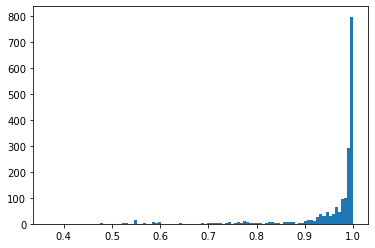

In [75]:
plt.hist(confidence, bins=100)

In [76]:
pd.DataFrame(np.sort(confidence)[::-1]).to_csv("Confidence.csv")

In [77]:
correct = np.array([np.array_equal(a,b) for a,b in zip(y_test, results)])

In [78]:
results_dict = {"Correct":correct, "Confidence":confidence}
results_df = pd.DataFrame(results_dict)

In [79]:
boundary = 0.85

In [80]:
negatives = results_df[results_df["Confidence"]<boundary]
true_neg = negatives[negatives["Correct"]==False]
false_neg = negatives[negatives["Correct"]==True]

positives = results_df[results_df["Confidence"]>=boundary]
true_pos = positives[positives["Correct"]==True]
false_pos = positives[positives["Correct"]==False]

In [81]:
perc_true_neg = len(true_neg)*100/len(results_df)
perc_false_neg = len(false_neg)*100/len(results_df)

perc_true_pos = len(true_pos)*100/len(results_df)
perc_false_pos = len(false_pos)*100/len(results_df)

In [82]:
print("True Negatives: " + str(perc_true_neg) + "%")
print("False Negatives: " + str(perc_false_neg) + "%")
print("True Positives: " + str(perc_true_pos) + "%")
print("False Positives: " + str(perc_false_pos) + "%")

True Negatives: 3.956043956043956%
False Negatives: 3.791208791208791%
True Positives: 83.73626373626374%
False Positives: 8.516483516483516%


In [83]:
results_df

Correct  Confidence
0       False    0.707627
1       False    0.703121
2       False    0.855854
3       False    0.717929
4       False    0.822868
...       ...         ...
1815    False    0.583610
1816    False    0.999212
1817    False    0.943221
1818    False    0.998912
1819    False    0.997236

[1820 rows x 2 columns]

### Old Code -------------------- Don't look at this from here on. I just leave it because some bits are useful for me

In [79]:
pred = pd.concat([pred_1,pred_2],axis=1).astype(int)

In [80]:
test = y_test.copy()
#test = pd.concat([pd.DataFrame(test_1, columns = header_1).reset_index(drop=True), pd.DataFrame(test_2, columns = header_2).reset_index(drop=True)], axis=1)

In [81]:
#The actual and predicted dataframes have headers sorted differently, so we equal them
test = test[list(pred)]

In [82]:
acc_list = [test.iloc[i].values.tolist() == pred.iloc[i].values.tolist() for i in range(0,len(test))]

In [83]:
test_tags = [list(filter(None, test.iloc[i].values * test.columns.values)) for i in range(0,len(test))]
pred_tags = [list(filter(None, pred.iloc[i].values * pred.columns.values)) for i in range(0,len(pred))]

In [84]:
dict_results = {"Label Name":X_test["navName"].values.tolist(),"Actual Tags":test_tags,"Predicted Tags":pred_tags, "Success":acc_list, "Prediction confidence":prediction_confidence, "No Revision Needed":revision_needed}

In [85]:
accuracy_total = (len(acc_list) - acc_list.count(False))/len(acc_list)*100

In [86]:
accuracy_total

86.20879120879121

In [87]:
results = pd.DataFrame(dict_results)
results

Label Name  \
0      5thFlr DX3 Cash Office Enable   
1       DX Unit 3 5th Post Room Temp   
2          6thFlr DX1 Kitchen Enable   
3        DX Unit 1 Kitchen Room Temp   
4          6thFlr DX2 Meeting Enable   
5     DX Unit 2 6th Meeting Room Tmp   
6                   Chiller 1 Enable   
7                 Chiller No.1 Fault   
8                   Chiller No.1 Run   
9                   Chiller 2 Enable   
10                Chiller No.2 Fault   
11                  Chiller No.2 Run   
12                  Chiller Core Hrs   
13                 Chiller Flow Temp   
14               Chiller Return Temp   
15           ChW Calculated Setpoint   
16                 CHW Pump 1 Enable   
17               CHW Pump1 inv Fault   
18             CHW Pump1 Inverter OP   
19                   CWSPriPump1Fail   
20              CWSPump1 Speed Setpt   
21                 CHW Pump 2 Enable   
22                    CHW Pump2 Flow   
23               CHW Pump2 inv Fault   
24             CHW Pump2 Inverter OP   
25                   CWSPriPump2Fail   
26              CWSPump2 Speed Setpt   
27       Chilllers Eco Mode Setpoint   
28                    CHW Pump1 Flow   
29                   CHW PUnit Fault   
...                              ...   
1790              WestAHU RAC Enable   
1791                WestAHU RAC Trip   
1792               WestAHU RAC Valve   
1793             WestAHU SFan Failed   
1794            WestAHUSFan Inverter   
1795              WestAHU SFan 0-10V   
1796             WestAHU SFan Enable   
1797                WestAHU SFan Run   
1798          West  AHU Supply Setpt   
1799          West  AHU Supply Setpt   
1800                    West AHU CO2   
1801               West AHU Core Hrs   
1802           West AHU Sup Humidity   
1803            West AHU Supply Temp   
1804           WestAHU Cooling Valve   
1805             WestAHU DeHum Setpt   
1806             WestAHU EFan Damper   
1807            WestAHU Extract Temp   
1808    WestAHU Frost Stat Condition   
1809         WestAHU Frost Stat Trip   
1810             WestAHU Frost Valve   
1811           WestAHU Heating Valve   
1812               WestAHU Hum Fault   
1813       WestAHU Humidifier Enable   
1814           WestAHU Humidifier OP   
1815          WestAHU Humidity Setpt   
1816             WestAHU SFan Damper   
1817            WestAHU SupTmp Alarm   
1818              WestAHUEFan Damper   
1819              WestAHUSFan Damper   

                                   Actual Tags  \
0                                        [cmd]   
1                          [sensor, air, temp]   
2                                        [cmd]   
3                          [sensor, air, temp]   
4                                        [cmd]   
5                          [sensor, air, temp]   
6                                   [cmd, run]   
7                              [sensor, alarm]   
8                                [sensor, run]   
9                                   [cmd, run]   
10                             [sensor, alarm]   
11                               [sensor, run]   
12                              [sp, occupied]   
13     [sensor, chilled, leaving, temp, water]   
14    [sensor, chilled, entering, temp, water]   
15                 [sp, entering, temp, water]   
16                                  [cmd, run]   
17                             [sensor, alarm]   
18                                [cmd, speed]   
19                             [sensor, alarm]   
20                                        [sp]   
21                                  [cmd, run]   
22                               [sensor, run]   
23                             [sensor, alarm]   
24                                [cmd, speed]   
25                             [sensor, alarm]   
26                                        [sp]   
27                                        [sp]   
28                                    [sensor]   
29                             [sensor, alarm

In [88]:
len(results)

1820

In [89]:
no_success = results[results["Success"]==False]

In [90]:
54/1820

0.02967032967032967

In [91]:
len(no_success)

251

In [92]:
len(no_success[no_success["No Revision Needed"]==True])

58

In [93]:
false_possitives = no_success[no_success["No Revision Needed"]==True]

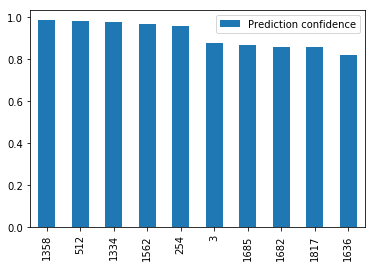

In [101]:
#df = pd.DataFrame({'lab':['A', 'B', 'C'], 'val':[10, 30, 20]})
ax = false_possitives[["Label Name","Prediction confidence"]].sort_values(by=["Prediction confidence"], ascending=False).iloc[-10:].plot.bar(rot=90)

In [95]:
false_possitives

Label Name                     Actual Tags  \
3        DX Unit 1 Kitchen Room Temp             [sensor, air, temp]   
53                 Generator On Load                 [sensor, alarm]   
254                  Plant Room Temp             [sensor, air, temp]   
332                       Space temp       [sensor, air, temp, zone]   
338                       Space temp       [sensor, air, temp, zone]   
494                       Space temp       [sensor, air, temp, zone]   
500                       Space temp       [sensor, air, temp, zone]   
506                       Space temp       [sensor, air, temp, zone]   
512                       Space temp       [sensor, air, temp, zone]   
1190                      Space temp       [sensor, air, temp, zone]   
1196                      Space temp       [sensor, air, temp, zone]   
1202                      Space temp       [sensor, air, temp, zone]   
1214                      Space temp       [sensor, air, temp, zone]   
1226                      Space temp       [sensor, air, temp, zone]   
1232                      Space temp       [sensor, air, temp, zone]   
1238                      Space temp       [sensor, air, temp, zone]   
1256                      Space temp       [sensor, air, temp, zone]   
1262                      Space temp       [sensor, air, temp, zone]   
1268                      Space temp       [sensor, air, temp, zone]   
1274                      Space temp       [sensor, air, temp, zone]   
1280                      Space temp       [sensor, air, temp, zone]   
1286                      Space temp       [sensor, air, temp, zone]   
1304                      Space temp       [sensor, air, temp, zone]   
1310                      Space temp       [sensor, air, temp, zone]   
1316                      Space temp       [sensor, air, temp, zone]   
1322                      Space temp       [sensor, air, temp, zone]   
1328                      Space temp       [sensor, air, temp, zone]   
1334                      Space temp       [sensor, air, temp, zone]   
1340                      Space temp       [sensor, air, temp, zone]   
1346                      Space temp       [sensor, air, temp, zone]   
1352                      Space temp       [sensor, air, temp, zone]   
1358                      Space temp       [sensor, air, temp, zone]   
1539                      Space temp       [sensor, air, temp, zone]   
1562                 UPS Room Temp 1       [sensor, air, temp, zone]   
1604  Atrium3rd Stage Frost Setpoint                 [sp, air, temp]   
1631                EastAHU EFan Run                   [sensor, run]   
1636              East  AHU Deadband                            [sp]   
1648             EastAHU SFan Enable                      [cmd, run]   
1649                EastAHU SFan Run                   [sensor, run]   
1654                KitAHU EFan Flow                   [sensor, run]   
1677                KitAHU SFan Flow                   [sensor, run]   
1682         LB AHU Supply Flow Fail  [sensor, air, discharge, flow]   
1685        LB AHU Supply Temp Alarm  [sensor, air, discharge, flow]   
1690    Low Bsmnt Smoke Ext Fan Flow                   [sensor, run]   
1700         LB AHU Frost Coil Setpt                 [sp, air, temp]   
1711          LoadingBay SE Fan Flow                   [sensor, run]   
1718           CarParkLBas EFan Flow                   [sensor, run]   
1719            Low Base CP Ext LL01                      [cmd, run]   
1727           Main Lift EFan Enable                      [cmd, run]   
1731            Sat Lift EFan Enable                      [cmd, run]   
1736             Sub Station Ext Fan                      [cmd, run]   
1764        Up Base CP Ext EF04 High                      [cmd, run]   
1765         Up Base CP Ext EF04 Low                      [cmd, run]   
1781             WestAHU EFan Enable                      [cmd, run]   
1782                WestAHU EFan Run                   [sensor, ru

In [96]:
X_train.shape

(40472, 9)

# Service type

In [97]:
serviceType = [[word] for word in data_serviceType["serviceType"].str.lower().values.tolist()]

In [98]:
#serviceType = data_serviceType["serviceType"].str.lower().values.tolist()

serviceType_train = serviceType_train.values.tolist()
serviceType_test = serviceType_test.values.tolist()

enc_servType = OneHotEncoder(handle_unknown='ignore')
#X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc_servType.fit(serviceType)

NameError: name 'serviceType_train' is not defined

In [ ]:
enc_servType.categories_

In [ ]:
serviceType_train = enc_servType.transform(serviceType_train)
serviceType_test = enc_servType.transform(serviceType_test)

serviceType_train = serviceType_train.astype('int')
serviceType_test = serviceType_test.astype('int')

In [ ]:
serviceType_train.shape

In [ ]:
serviceType_sparse_train = sparse.csr_matrix(serviceType_train)
serviceType_sparse_test = sparse.csr_matrix(serviceType_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [ ]:
#Preparing new test data (test_1 + predictions)
spredictions = sparse.csr_matrix(predictions_2) 
sX_test_3 = sparse.hstack([sX_test_2,spredictions])

#Preparing new training data (train_1 + y_train_1)
sX_train_3 = sparse.hstack([sX_train_2,y_train_2])

In [ ]:
%%time

# initialize label powerset multi-label classifier
classifier_1 = RandomForestClassifier(n_estimators=100)

# train
classifier_1.fit(sX_train_3, serviceType_sparse_train.toarray())

# predict
predictions = classifier_1.predict(sX_test_3)
#predictions_val = classifier_1.predict(data_val)

# accuracy
print("Accuracy = ",accuracy_score(serviceType_test,predictions))
print("\n")